In [1]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
m = pd.read_csv('dataset/ceb-matrix.csv', index_col='filename').to_numpy()
pg_total = m[:, 0].sum()
optimal_total = np.min(m, axis=1).sum()
print('pg_total:', pg_total)
print('optimal_total:', optimal_total)

pg_p90 = np.percentile(m[:, 0], 90)
optimal_p90 = np.percentile(np.min(m, axis=1), 90)
print('pg_p90:', pg_p90)
print('optimal_p90:', optimal_p90)

pg_total: 10587.665450334549
optimal_total: 3688.4883341789246
pg_p90: 4.558033323287964
optimal_p90: 2.603392314910889


In [3]:
def get_data(filename):
    total_latency = []
    p50 = []
    p90 = []
    p95 = []
    p99 = []
    execution_time = []
    training_time = []
    inference_time = []
    mse = []

    with open(filename) as f:
        results = json.load(f)
        for result in results:
            total_latency.append(result["total_latency"] / 3600)
            p50.append(result["p50"])
            p90.append(result["p90"])
            p95.append(result["p95"])
            p99.append(result["p99"])
            execution_time.append(result["exec_time"] / 3600 - pg_total / 3600)
            training_time.append(result["training_time"])
            inference_time.append(result["inference_time"])
            if "mse" in result:
                mse.append(result["mse"])
    
    training_time_cdf = np.cumsum(training_time)
    inference_time_cdf = np.cumsum(inference_time)
    pg_total_hour = pg_total / 3600
    df = pd.DataFrame({
        "total_latency": total_latency,
        "improvement": (pg_total_hour - total_latency) / pg_total_hour,
        "latency_median": p50,
        "latency_p90": p90,
        "latency_p95": p95,
        "latency_p99": p99,
        "execution_time": execution_time,
        # "execution_time": execution_time + (training_time_cdf + inference_time_cdf) / 3600,
        "training_time": training_time,
        "inference_time": inference_time,
    })
    df['overhead_time'] = df['training_time'] + df['inference_time']
    df['overhead_time_cdf'] = df['overhead_time'].cumsum()
    
    if len(mse) > 0:
        df["mse"] = mse
    
    return df

In [4]:
def combine_plot(p_mc_lists, mc_lists):

    start = -np.inf
    end = np.inf
    for i in range(len(p_mc_lists)):
        p_min = np.min(p_mc_lists[i])
        p_max = np.max(p_mc_lists[i])
        start = max(start, p_min)
        end = min(end, p_max)
    
    
    x_combined = np.linspace(start, end, 5000)
    y_combined = np.zeros_like(x_combined)
    fi_list = []
    for i in range(len(p_mc_lists)):
        fi = interp1d(p_mc_lists[i], mc_lists[i], kind='linear')
        y_combined += fi(x_combined)
        fi_list.append(fi(x_combined))

    y_combined = y_combined / len(p_mc_lists)
    std = np.std(fi_list, axis=0)
    
    return x_combined, y_combined, std

def get_multiple(path, x_name, y_name, n=20):

    x_list, y_list = [], []
    for i in range(1,n+1):
        df = get_data(path.format(i))
        x_list.append(df[x_name])
        y_list.append(df[y_name])
    
    x_combined, y_combined, std = combine_plot(x_list, y_list)
    
    return x_combined, y_combined, std

In [37]:
linewidth=3
markersize=10
gridwidth=1.5
bwith=2
ticks_fontsize=16.5
label_fontsize=20
title_fontsize=20
fontweight='normal'
markeredgecolor = 'k'
color_scheme = [
    "#4995c6",  # 蓝色
    "#d47628",  # 黄色
    "#8fb943",  # 绿色
    "#d15c6b",  # 红色
    "#8481ba",  # 紫色
    "#413123",  # 棕色
    "#f7a128",  # 橙色,
    "#a5a5a5",  # 灰色,
    "#011F5B",  # 深蓝色
]

line_styles = ['-', '--', '-.', ':', '-', '--']

/var/folders/sr/6vwss26n2kz07f4659hh1lp80000gq/T/ipykernel_19938/2281517041.py:45: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 3000)
/var/folders/sr/6vwss26n2kz07f4659hh1lp80000gq/T/ipykernel_19938/2281517041.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([-0.1,0, 0.1, 1, 10, 100, 1000])


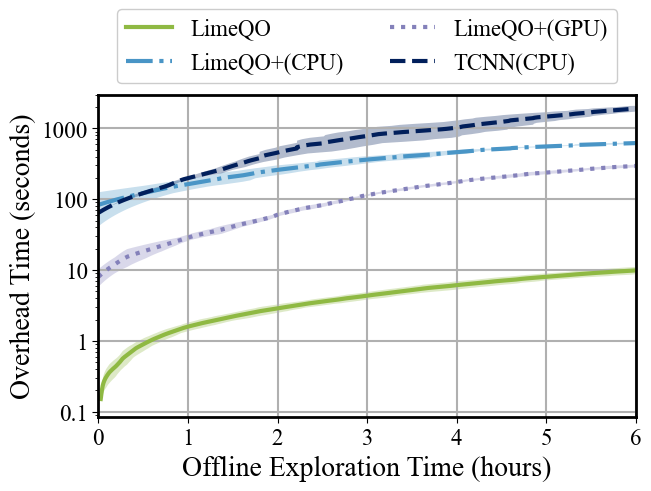

In [46]:
fig, ax = plt.subplots(1,1,constrained_layout=True)

# set font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
ax.tick_params(axis='x', labelsize=ticks_fontsize, length=4)
ax.tick_params(axis='y', labelsize=ticks_fontsize, length=4)
# axi.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center')
ax.grid(linewidth=gridwidth)

x, y, std = get_multiple("experiment/ceb/limeqo/{}.json", "execution_time", "overhead_time_cdf", n=20)
ax.plot(x, y, color = color_scheme[2], label='LimeQO', linestyle=line_styles[0],  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[2], linewidth=0)

x, y, std = get_multiple("experiment/ceb/limeqo+/{}.json", "execution_time", "overhead_time_cdf", n=5)
ax.plot(x, y, color = color_scheme[0], label='LimeQO+(CPU)', linestyle=line_styles[2],  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[0], linewidth=0)

x, y, std = get_multiple("experiment/ceb/limeqo+/rank5/{}.json", "execution_time", "overhead_time_cdf", n=5)
ax.plot(x, y, color = color_scheme[4], label='LimeQO+(GPU)', linestyle=line_styles[3],  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[4], linewidth=0)

x, y, std = get_multiple("experiment/ceb/tcnn/{}.json", "execution_time", "overhead_time_cdf", n=2)
ax.plot(x, y, color = color_scheme[8], label='TCNN(CPU)', linestyle=line_styles[1],  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[8], linewidth=0)

# df = get_data("experiment/ceb/bao/bao_1.json")
# ax.plot(df["execution_time"], df["total_latency"], color = color_scheme[6], label='Bao', linestyle=line_styles[0],  linewidth=linewidth)

# df = get_data("experiment/ceb/oracle.json")
# ax.plot(df["execution_time"], df["total_latency"], color = color_scheme[4], label='Oracle', linestyle=line_styles[4],  linewidth=linewidth)

ax.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center',ncol=2, bbox_to_anchor=(0.5, 1.3))
ax.grid('--')
ax.set_yscale('log')
ax.set_xlim(-0, 6)
ax.set_ylim(0, 3000)
ax.set_yticklabels([-0.1,0, 0.1, 1, 10, 100, 1000])
ax.set_ylabel('Overhead Time (seconds)', fontsize=label_fontsize, fontweight=fontweight)
ax.set_xlabel('Offline Exploration Time (hours)', fontsize=label_fontsize, fontweight=fontweight)

plt.savefig('fig/overhead.pdf', bbox_inches='tight')